In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, random_state=0):
    
    np.random.seed(random_state)
    x = np.zeros((datanum, 10))
    for i in range(10):
        x[:, i:i+1] = np.random.uniform(0, 1,[datanum,1])
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = [x[:, [i]] for i in range(10)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
         + 0.1 * np.exp(-8 * x2 + 4)
         + 3 * np.sin(2 * np.pi * x3 * x4)
         + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X1":{"type":'continuous'},
             'X2':{'type':'continuous'},
             'X3':{'type':'continuous'},
             'X4':{'type':'continuous'},
             'X5':{'type':'continuous'},
             'X6':{'type':'continuous'},
             'X7':{'type':'continuous'},
             'X8':{'type':'continuous'},
             'X9':{'type':'continuous'},
             'X10':{'type':'continuous'},
             'Y':{'type':'target'}}
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=5000, random_state=1)

## Train GAMI-Net 

In [3]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
            interact_arch=[40] * 5, subnet_arch=[40] * 5,
            lr_bp=0.0001, batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
            main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=500, early_stop_thres=60,
            heredity=True, loss_threshold=0.01, reg_clarity=1,
            verbose=True, val_ratio=0.2, random_state=0)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.15370, val loss: 0.15357
Main effects training epoch: 2, train loss: 0.12374, val loss: 0.12327
Main effects training epoch: 3, train loss: 0.09393, val loss: 0.09320
Main effects training epoch: 4, train loss: 0.06695, val loss: 0.06597
Main effects training epoch: 5, train loss: 0.04452, val loss: 0.04331
Main effects training epoch: 6, train loss: 0.02867, val loss: 0.02727
Main effects training epoch: 7, train loss: 0.02094, val loss: 0.01939
Main effects training epoch: 8, train loss: 0.01933, val loss: 0.01772
Main effects training epoch: 9, train loss: 0.01910, val loss: 0.01754
Main effects training epoch: 10, train loss: 0.01885, val loss: 0.01734
Main effects training epoch: 11, train loss: 0.01862, val loss: 0.01717
Main effects training epoch: 12, train loss: 0.01840, val loss: 0.01701
Main effects training e

Main effects training epoch: 114, train loss: 0.01031, val loss: 0.01049
Main effects training epoch: 115, train loss: 0.01028, val loss: 0.01049
Main effects training epoch: 116, train loss: 0.01028, val loss: 0.01049
Main effects training epoch: 117, train loss: 0.01028, val loss: 0.01047
Main effects training epoch: 118, train loss: 0.01032, val loss: 0.01051
Main effects training epoch: 119, train loss: 0.01027, val loss: 0.01050
Main effects training epoch: 120, train loss: 0.01027, val loss: 0.01050
Main effects training epoch: 121, train loss: 0.01026, val loss: 0.01048
Main effects training epoch: 122, train loss: 0.01029, val loss: 0.01050
Main effects training epoch: 123, train loss: 0.01026, val loss: 0.01047
Main effects training epoch: 124, train loss: 0.01026, val loss: 0.01048
Main effects training epoch: 125, train loss: 0.01026, val loss: 0.01048
Main effects training epoch: 126, train loss: 0.01026, val loss: 0.01045
Main effects training epoch: 127, train loss: 0.010

Main effects training epoch: 227, train loss: 0.01007, val loss: 0.01040
Main effects training epoch: 228, train loss: 0.01006, val loss: 0.01040
Main effects training epoch: 229, train loss: 0.01005, val loss: 0.01039
Main effects training epoch: 230, train loss: 0.01006, val loss: 0.01038
Main effects training epoch: 231, train loss: 0.01009, val loss: 0.01046
Main effects training epoch: 232, train loss: 0.01004, val loss: 0.01039
Main effects training epoch: 233, train loss: 0.01005, val loss: 0.01037
Main effects training epoch: 234, train loss: 0.01007, val loss: 0.01041
Main effects training epoch: 235, train loss: 0.01003, val loss: 0.01039
Main effects training epoch: 236, train loss: 0.01006, val loss: 0.01039
Main effects training epoch: 237, train loss: 0.01004, val loss: 0.01040
Main effects training epoch: 238, train loss: 0.01002, val loss: 0.01039
Main effects training epoch: 239, train loss: 0.01005, val loss: 0.01039
Main effects training epoch: 240, train loss: 0.010

Main effects training epoch: 340, train loss: 0.00954, val loss: 0.01008
Main effects training epoch: 341, train loss: 0.00954, val loss: 0.01001
Main effects training epoch: 342, train loss: 0.00955, val loss: 0.01006
Main effects training epoch: 343, train loss: 0.00953, val loss: 0.01003
Main effects training epoch: 344, train loss: 0.00958, val loss: 0.01009
Main effects training epoch: 345, train loss: 0.00953, val loss: 0.01004
Main effects training epoch: 346, train loss: 0.00958, val loss: 0.01002
Main effects training epoch: 347, train loss: 0.00954, val loss: 0.01006
Main effects training epoch: 348, train loss: 0.00956, val loss: 0.01005
Main effects training epoch: 349, train loss: 0.00953, val loss: 0.01007
Main effects training epoch: 350, train loss: 0.00956, val loss: 0.01001
Main effects training epoch: 351, train loss: 0.00953, val loss: 0.01008
Main effects training epoch: 352, train loss: 0.00953, val loss: 0.01001
Main effects training epoch: 353, train loss: 0.009

Main effects training epoch: 454, train loss: 0.00947, val loss: 0.01001
Main effects training epoch: 455, train loss: 0.00948, val loss: 0.01000
Main effects training epoch: 456, train loss: 0.00947, val loss: 0.01002
Main effects training epoch: 457, train loss: 0.00946, val loss: 0.00996
Main effects training epoch: 458, train loss: 0.00947, val loss: 0.01001
Main effects training epoch: 459, train loss: 0.00946, val loss: 0.00998
Main effects training epoch: 460, train loss: 0.00951, val loss: 0.01006
Main effects training epoch: 461, train loss: 0.00946, val loss: 0.00998
Main effects training epoch: 462, train loss: 0.00950, val loss: 0.01004
Main effects training epoch: 463, train loss: 0.00946, val loss: 0.01000
Main effects training epoch: 464, train loss: 0.00947, val loss: 0.01000
Main effects training epoch: 465, train loss: 0.00949, val loss: 0.01002
Main effects training epoch: 466, train loss: 0.00946, val loss: 0.00997
Main effects training epoch: 467, train loss: 0.009

Interaction training epoch: 100, train loss: 0.00439, val loss: 0.00484
Interaction training epoch: 101, train loss: 0.00439, val loss: 0.00479
Interaction training epoch: 102, train loss: 0.00436, val loss: 0.00485
Interaction training epoch: 103, train loss: 0.00437, val loss: 0.00488
Interaction training epoch: 104, train loss: 0.00436, val loss: 0.00480
Interaction training epoch: 105, train loss: 0.00435, val loss: 0.00483
Interaction training epoch: 106, train loss: 0.00435, val loss: 0.00484
Interaction training epoch: 107, train loss: 0.00435, val loss: 0.00486
Interaction training epoch: 108, train loss: 0.00435, val loss: 0.00481
Interaction training epoch: 109, train loss: 0.00435, val loss: 0.00486
Interaction training epoch: 110, train loss: 0.00434, val loss: 0.00478
Interaction training epoch: 111, train loss: 0.00434, val loss: 0.00481
Interaction training epoch: 112, train loss: 0.00433, val loss: 0.00475
Interaction training epoch: 113, train loss: 0.00433, val loss: 

Interaction training epoch: 214, train loss: 0.00406, val loss: 0.00465
Interaction training epoch: 215, train loss: 0.00404, val loss: 0.00462
Interaction training epoch: 216, train loss: 0.00403, val loss: 0.00455
Interaction training epoch: 217, train loss: 0.00404, val loss: 0.00455
Interaction training epoch: 218, train loss: 0.00402, val loss: 0.00458
Interaction training epoch: 219, train loss: 0.00404, val loss: 0.00452
Interaction training epoch: 220, train loss: 0.00406, val loss: 0.00456
Interaction training epoch: 221, train loss: 0.00403, val loss: 0.00454
Interaction training epoch: 222, train loss: 0.00400, val loss: 0.00454
Interaction training epoch: 223, train loss: 0.00401, val loss: 0.00451
Interaction training epoch: 224, train loss: 0.00400, val loss: 0.00453
Interaction training epoch: 225, train loss: 0.00401, val loss: 0.00456
Interaction training epoch: 226, train loss: 0.00401, val loss: 0.00453
Interaction training epoch: 227, train loss: 0.00401, val loss: 

Interaction training epoch: 328, train loss: 0.00359, val loss: 0.00420
Interaction training epoch: 329, train loss: 0.00369, val loss: 0.00427
Interaction training epoch: 330, train loss: 0.00358, val loss: 0.00419
Interaction training epoch: 331, train loss: 0.00357, val loss: 0.00420
Interaction training epoch: 332, train loss: 0.00357, val loss: 0.00422
Interaction training epoch: 333, train loss: 0.00357, val loss: 0.00424
Interaction training epoch: 334, train loss: 0.00355, val loss: 0.00421
Interaction training epoch: 335, train loss: 0.00355, val loss: 0.00419
Interaction training epoch: 336, train loss: 0.00355, val loss: 0.00422
Interaction training epoch: 337, train loss: 0.00354, val loss: 0.00415
Interaction training epoch: 338, train loss: 0.00356, val loss: 0.00417
Interaction training epoch: 339, train loss: 0.00354, val loss: 0.00415
Interaction training epoch: 340, train loss: 0.00353, val loss: 0.00417
Interaction training epoch: 341, train loss: 0.00351, val loss: 

Interaction training epoch: 442, train loss: 0.00289, val loss: 0.00347
Interaction training epoch: 443, train loss: 0.00289, val loss: 0.00350
Interaction training epoch: 444, train loss: 0.00292, val loss: 0.00356
Interaction training epoch: 445, train loss: 0.00291, val loss: 0.00342
Interaction training epoch: 446, train loss: 0.00287, val loss: 0.00342
Interaction training epoch: 447, train loss: 0.00290, val loss: 0.00356
Interaction training epoch: 448, train loss: 0.00287, val loss: 0.00345
Interaction training epoch: 449, train loss: 0.00286, val loss: 0.00342
Interaction training epoch: 450, train loss: 0.00287, val loss: 0.00349
Interaction training epoch: 451, train loss: 0.00287, val loss: 0.00344
Interaction training epoch: 452, train loss: 0.00284, val loss: 0.00347
Interaction training epoch: 453, train loss: 0.00285, val loss: 0.00341
Interaction training epoch: 454, train loss: 0.00285, val loss: 0.00350
Interaction training epoch: 455, train loss: 0.00283, val loss: 

Interaction training epoch: 556, train loss: 0.00252, val loss: 0.00309
Interaction training epoch: 557, train loss: 0.00249, val loss: 0.00304
Interaction training epoch: 558, train loss: 0.00259, val loss: 0.00307
Interaction training epoch: 559, train loss: 0.00248, val loss: 0.00304
Interaction training epoch: 560, train loss: 0.00248, val loss: 0.00302
Interaction training epoch: 561, train loss: 0.00249, val loss: 0.00299
Interaction training epoch: 562, train loss: 0.00249, val loss: 0.00309
Interaction training epoch: 563, train loss: 0.00252, val loss: 0.00313
Interaction training epoch: 564, train loss: 0.00256, val loss: 0.00316
Interaction training epoch: 565, train loss: 0.00252, val loss: 0.00309
Interaction training epoch: 566, train loss: 0.00253, val loss: 0.00309
Interaction training epoch: 567, train loss: 0.00247, val loss: 0.00304
Interaction training epoch: 568, train loss: 0.00247, val loss: 0.00308
Interaction training epoch: 569, train loss: 0.00246, val loss: 

Interaction training epoch: 670, train loss: 0.00234, val loss: 0.00293
Interaction training epoch: 671, train loss: 0.00227, val loss: 0.00291
Interaction training epoch: 672, train loss: 0.00230, val loss: 0.00289
Interaction training epoch: 673, train loss: 0.00226, val loss: 0.00289
Interaction training epoch: 674, train loss: 0.00229, val loss: 0.00289
Interaction training epoch: 675, train loss: 0.00229, val loss: 0.00294
Interaction training epoch: 676, train loss: 0.00226, val loss: 0.00287
Interaction training epoch: 677, train loss: 0.00227, val loss: 0.00289
Interaction training epoch: 678, train loss: 0.00229, val loss: 0.00293
Interaction training epoch: 679, train loss: 0.00227, val loss: 0.00287
Interaction training epoch: 680, train loss: 0.00226, val loss: 0.00288
Interaction training epoch: 681, train loss: 0.00231, val loss: 0.00301
Interaction training epoch: 682, train loss: 0.00236, val loss: 0.00293
Interaction training epoch: 683, train loss: 0.00224, val loss: 

Interaction training epoch: 784, train loss: 0.00209, val loss: 0.00278
Interaction training epoch: 785, train loss: 0.00211, val loss: 0.00278
Interaction training epoch: 786, train loss: 0.00210, val loss: 0.00279
Interaction training epoch: 787, train loss: 0.00215, val loss: 0.00276
Interaction training epoch: 788, train loss: 0.00207, val loss: 0.00279
Interaction training epoch: 789, train loss: 0.00209, val loss: 0.00280
Interaction training epoch: 790, train loss: 0.00208, val loss: 0.00277
Interaction training epoch: 791, train loss: 0.00210, val loss: 0.00281
Interaction training epoch: 792, train loss: 0.00207, val loss: 0.00274
Interaction training epoch: 793, train loss: 0.00219, val loss: 0.00289
Interaction training epoch: 794, train loss: 0.00211, val loss: 0.00280
Interaction training epoch: 795, train loss: 0.00215, val loss: 0.00288
Interaction training epoch: 796, train loss: 0.00206, val loss: 0.00274
Interaction training epoch: 797, train loss: 0.00206, val loss: 

Interaction training epoch: 898, train loss: 0.00191, val loss: 0.00272
Interaction training epoch: 899, train loss: 0.00189, val loss: 0.00260
Interaction training epoch: 900, train loss: 0.00190, val loss: 0.00267
Interaction training epoch: 901, train loss: 0.00201, val loss: 0.00278
Interaction training epoch: 902, train loss: 0.00189, val loss: 0.00262
Interaction training epoch: 903, train loss: 0.00190, val loss: 0.00266
Interaction training epoch: 904, train loss: 0.00189, val loss: 0.00264
Interaction training epoch: 905, train loss: 0.00192, val loss: 0.00268
Interaction training epoch: 906, train loss: 0.00190, val loss: 0.00263
Interaction training epoch: 907, train loss: 0.00192, val loss: 0.00265
Interaction training epoch: 908, train loss: 0.00187, val loss: 0.00262
Interaction training epoch: 909, train loss: 0.00187, val loss: 0.00266
Interaction training epoch: 910, train loss: 0.00196, val loss: 0.00264
Interaction training epoch: 911, train loss: 0.00191, val loss: 

Interaction training epoch: 1012, train loss: 0.00174, val loss: 0.00251
Interaction training epoch: 1013, train loss: 0.00176, val loss: 0.00258
Interaction training epoch: 1014, train loss: 0.00172, val loss: 0.00254
Interaction training epoch: 1015, train loss: 0.00176, val loss: 0.00248
Interaction training epoch: 1016, train loss: 0.00175, val loss: 0.00257
Interaction training epoch: 1017, train loss: 0.00172, val loss: 0.00254
Interaction training epoch: 1018, train loss: 0.00171, val loss: 0.00252
Interaction training epoch: 1019, train loss: 0.00173, val loss: 0.00253
Interaction training epoch: 1020, train loss: 0.00174, val loss: 0.00251
Interaction training epoch: 1021, train loss: 0.00172, val loss: 0.00255
Interaction training epoch: 1022, train loss: 0.00174, val loss: 0.00259
Interaction training epoch: 1023, train loss: 0.00170, val loss: 0.00251
Interaction training epoch: 1024, train loss: 0.00171, val loss: 0.00254
Interaction training epoch: 1025, train loss: 0.001

Interaction training epoch: 1125, train loss: 0.00159, val loss: 0.00250
Interaction training epoch: 1126, train loss: 0.00158, val loss: 0.00239
Interaction training epoch: 1127, train loss: 0.00164, val loss: 0.00248
Interaction training epoch: 1128, train loss: 0.00169, val loss: 0.00251
Interaction training epoch: 1129, train loss: 0.00163, val loss: 0.00254
Interaction training epoch: 1130, train loss: 0.00159, val loss: 0.00239
Interaction training epoch: 1131, train loss: 0.00161, val loss: 0.00244
Interaction training epoch: 1132, train loss: 0.00158, val loss: 0.00248
Interaction training epoch: 1133, train loss: 0.00159, val loss: 0.00246
Interaction training epoch: 1134, train loss: 0.00163, val loss: 0.00251
Interaction training epoch: 1135, train loss: 0.00161, val loss: 0.00247
Interaction training epoch: 1136, train loss: 0.00161, val loss: 0.00248
Interaction training epoch: 1137, train loss: 0.00158, val loss: 0.00248
Interaction training epoch: 1138, train loss: 0.001

Interaction training epoch: 1238, train loss: 0.00150, val loss: 0.00231
Interaction training epoch: 1239, train loss: 0.00152, val loss: 0.00241
Interaction training epoch: 1240, train loss: 0.00148, val loss: 0.00239
Interaction training epoch: 1241, train loss: 0.00149, val loss: 0.00238
Interaction training epoch: 1242, train loss: 0.00148, val loss: 0.00236
Interaction training epoch: 1243, train loss: 0.00149, val loss: 0.00240
Interaction training epoch: 1244, train loss: 0.00155, val loss: 0.00248
Interaction training epoch: 1245, train loss: 0.00148, val loss: 0.00240
Interaction training epoch: 1246, train loss: 0.00147, val loss: 0.00235
Interaction training epoch: 1247, train loss: 0.00150, val loss: 0.00237
Interaction training epoch: 1248, train loss: 0.00149, val loss: 0.00243
Interaction training epoch: 1249, train loss: 0.00150, val loss: 0.00238
Interaction training epoch: 1250, train loss: 0.00150, val loss: 0.00239
Interaction training epoch: 1251, train loss: 0.001

Fine tuning epoch: 22, train loss: 0.00182, val loss: 0.00218
Fine tuning epoch: 23, train loss: 0.00182, val loss: 0.00218
Fine tuning epoch: 24, train loss: 0.00178, val loss: 0.00211
Fine tuning epoch: 25, train loss: 0.00182, val loss: 0.00221
Fine tuning epoch: 26, train loss: 0.00179, val loss: 0.00208
Fine tuning epoch: 27, train loss: 0.00178, val loss: 0.00212
Fine tuning epoch: 28, train loss: 0.00177, val loss: 0.00211
Fine tuning epoch: 29, train loss: 0.00180, val loss: 0.00211
Fine tuning epoch: 30, train loss: 0.00179, val loss: 0.00213
Fine tuning epoch: 31, train loss: 0.00177, val loss: 0.00207
Fine tuning epoch: 32, train loss: 0.00178, val loss: 0.00213
Fine tuning epoch: 33, train loss: 0.00179, val loss: 0.00208
Fine tuning epoch: 34, train loss: 0.00179, val loss: 0.00213
Fine tuning epoch: 35, train loss: 0.00177, val loss: 0.00209
Fine tuning epoch: 36, train loss: 0.00186, val loss: 0.00223
Fine tuning epoch: 37, train loss: 0.00180, val loss: 0.00212
Fine tun

Fine tuning epoch: 154, train loss: 0.00172, val loss: 0.00204
Fine tuning epoch: 155, train loss: 0.00173, val loss: 0.00205
Fine tuning epoch: 156, train loss: 0.00174, val loss: 0.00213
Fine tuning epoch: 157, train loss: 0.00177, val loss: 0.00214
Fine tuning epoch: 158, train loss: 0.00172, val loss: 0.00199
Fine tuning epoch: 159, train loss: 0.00172, val loss: 0.00201
Fine tuning epoch: 160, train loss: 0.00180, val loss: 0.00218
Fine tuning epoch: 161, train loss: 0.00176, val loss: 0.00212
Fine tuning epoch: 162, train loss: 0.00171, val loss: 0.00206
Fine tuning epoch: 163, train loss: 0.00176, val loss: 0.00203
Fine tuning epoch: 164, train loss: 0.00176, val loss: 0.00213
Fine tuning epoch: 165, train loss: 0.00172, val loss: 0.00205
Fine tuning epoch: 166, train loss: 0.00171, val loss: 0.00200
Fine tuning epoch: 167, train loss: 0.00171, val loss: 0.00205
Fine tuning epoch: 168, train loss: 0.00173, val loss: 0.00205
Fine tuning epoch: 169, train loss: 0.00176, val loss: 

## Visualization

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

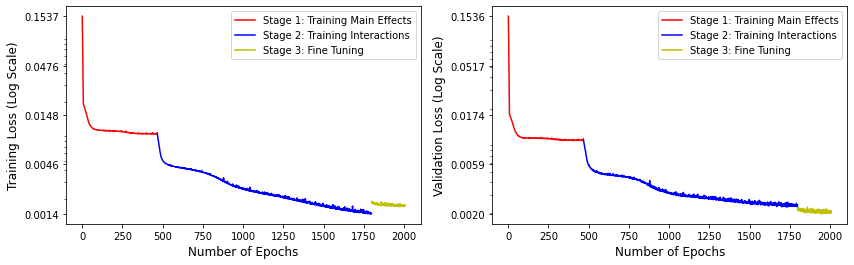

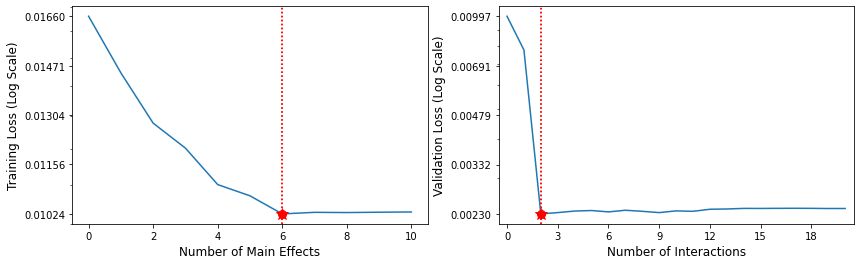

In [5]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

Global Visualization

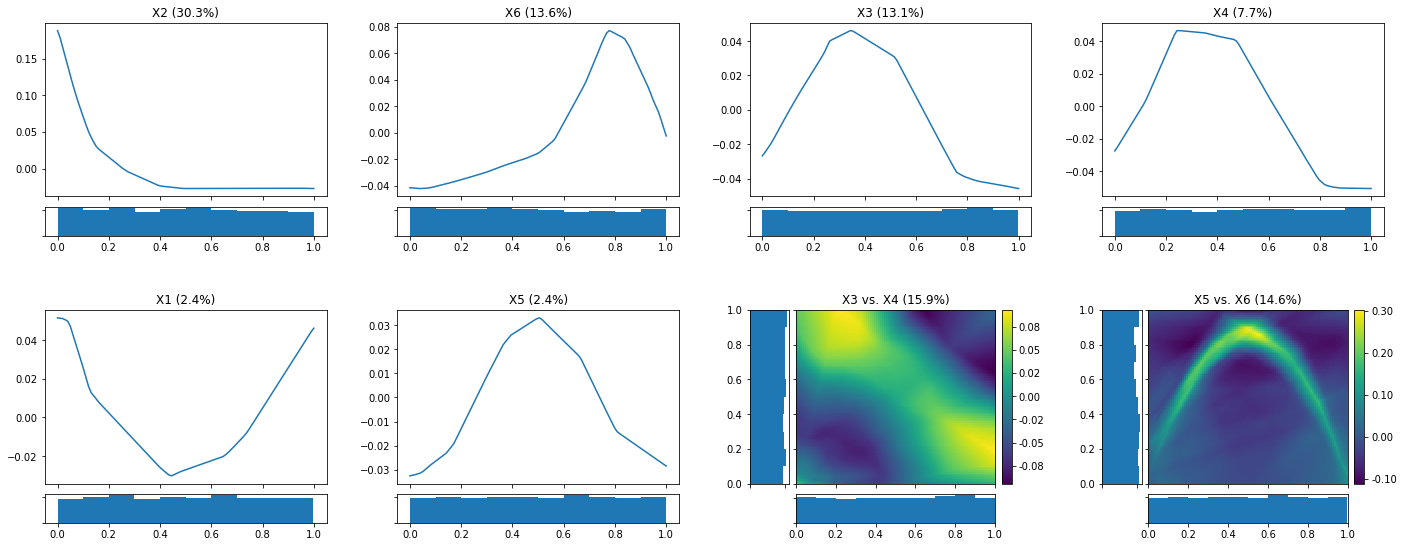

In [6]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, folder=simu_dir, name='s1_global')